<table class="table table-bordered">
    <tr>
        <th style="width:200px;">
            <img src='https://bcgriseacademy.com/hs-fs/hubfs/RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png?width=3522&height=1986&name=RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png' style="background-color:black; width: 100%; height: 100%;">
        </th>
        <th style="text-align:center;">
            <h1>RISE2.0 Business and Data Analytics</h1>
            <h2>IU 3.7.2.1 Machine Learning Project</h2>
            <h3>Business Case 3 - Ensemble Learning</h3>
        </th>
    </tr>
</table>

## Context

### Bank Customer Churn Prediction
Referring back to Business Case 1, the Chief Data Officer (CDO) of the retail bank is dissatisfied with the predictive performance of the classification model in identifying of customer churn. 

The CDO challenged the Data Analytics team to come up with better machine learning models using Ensemble Learning techniques. 

## Objectives
Based on what you have learnt in the course: 
1. Load the Bank Churn dataset and perform any necessary data preprocessing
2. Perform Exploratory Data Analysis (EDA) on the preprocessed dataset
3. Train, validate and evaluate Ensemble Learning models
4. Implement an optimal Ensemble Learning model to address specific business needs

## Dataset

You are provided with the following files:
1. bank_churn.csv
2. Data Dictionary - Bank Churn.xlsx

### Step 1: Import Data and Perform Data Preparation

#### 1.1 Import packages

In [52]:
# Import the required packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve, ClassPredictionError, DiscriminationThreshold

# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module='yellowbrick')

#### 1.2 Load data into DataFrame

In [2]:
# Import bank_churn_preprocessed dataset
df = pd.read_csv('Data/bank_churn_preprocessed.csv')

In [3]:
# Print first 5 rows
df.head()

,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Country_Germany,Country_Spain,Gender_Male,Churned
0,2,0.00,1,1,101348.88,0,0,0,1
1,1,83807.86,0,1,112542.58,0,1,0,0
2,8,159660.80,1,0,113931.57,0,0,0,1
3,1,0.00,0,0,93826.63,0,0,0,0
4,2,125510.82,1,1,79084.10,0,1,0,0


In [4]:
# Print last 5 rows
df.tail()

,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Country_Germany,Country_Spain,Gender_Male,Churned
9995,5,0.00,1,0,96270.64,0,0,1,0
9996,10,57369.61,1,1,101699.77,0,0,1,0
9997,7,0.00,0,1,42085.58,0,0,0,1
9998,3,75075.31,1,0,92888.52,1,0,1,1
9999,4,130142.79,1,0,38190.78,0,0,0,0


In [5]:
# Check shape
df.shape

(10000, 9)

In [6]:
# Check dtypes
df.dtypes

Tenure               int64
Balance            float64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Country_Germany      int64
Country_Spain        int64
Gender_Male          int64
Churned              int64
dtype: object

In [7]:
# Find duplicate rows across all columns
df[df.duplicated()]

,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Country_Germany,Country_Spain,Gender_Male,Churned


In [8]:
# Check for null values
print(df.isnull().sum().sum())

0


In [9]:
# Check for class imbalance
df['Churned'].value_counts(normalize=True)

Churned
0    0.7963
1    0.2037
Name: proportion, dtype: float64

**Note: Some class imbalance is evident.**

#### 1.3 Perform train-test split of data

In [10]:
# Set "Churned" as target feature and the rest as input features
X = df.drop('Churned', axis=1)
y = df['Churned']

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### Step 2: Train and Finetune the Ensemble Learning Models [16 marks]

#### 2.1 Model 1 - Create Random Forest Model

In [39]:
# Model Building

# Create an instance of a Random Forest Classifier

# Define the preprocessing for numerical features
numerical_features = ['Tenure', 'Balance', 'EstimatedSalary']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
# categorical_features = []
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# Define passthrough features
passthrough_features = ['HasCrCard', 'IsActiveMember', 'Country_Germany', 'Country_Spain', 'Gender_Male']

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        # ('cat', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', passthrough_features)
    ])


# Define RandomForestClassifier pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Define SMOTE pipeline with RandomForestClassifier
smote_pipeline_rf = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy='auto',
                    random_state=42)),
    ('rf_pipeline', rf_pipeline)
])

In [40]:
# Create parameter grid for RandomForestClassifier
rf_param_grid = {
    "rf_pipeline__classifier__n_estimators": [25, 50, 75, 100, 125, 150, 200, 250, 300],
    "rf_pipeline__classifier__criterion": ['gini', 'entropy'],
    "rf_pipeline__classifier__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [41]:
# Use GridSearchCV to find the optimal hyperparameters
grid_search_rf = GridSearchCV(smote_pipeline_rf, rf_param_grid, scoring='f1', cv=10)

In [42]:
# Fit the model on training datasets
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('rf_pipeline',
                                        Pipeline(steps=[('preprocessor',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Tenure',
                                                                                           'Balance',
                                                                                           'EstimatedSalary']),
                                                                                         ('passthrough',
                                                                                          'passthrough',
                                                                                          ['HasCrCard',
                                                                                           'IsActiveMember',
                                                                                           'Country_Germany',
                                                                                           'Country_Spain',
                                                                                           'Gender_Male'])])),
                                                        ('classifier',
                                                         RandomForestClassifier(n_jobs=-1,
                                                                                random_state=42))]))]),
             param_grid={'rf_pipeline__classifier__criterion': ['gini',
                                                                'entropy'],
                         'rf_pipeline__classifier__max_depth': [2, 3, 4, 5, 6,
                                                                7, 8, 9, 10],
                         'rf_pipeline__classifier__n_estimators': [25, 50, 75,
                                                                   100, 125,
                                                                   150, 200,
                                                                   250, 300]},
             scoring='f1')

In [43]:
# Retrieve the best parameters
grid_search_rf.best_params_

{'rf_pipeline__classifier__criterion': 'entropy',
 'rf_pipeline__classifier__max_depth': 3,
 'rf_pipeline__classifier__n_estimators': 75}

In [44]:
# Initialize and train the model with the best parameters
smote_pipeline_rf.set_params(**grid_search_rf.best_params_).fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf_pipeline',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Tenure',
                                                                    'Balance',
                                                                    'EstimatedSalary']),
                                                                  ('passthrough',
                                                                   'passthrough',
                                                                   ['HasCrCard',
                                                                    'IsActiveMember',
                                                                    'Country_Germany',
                                                                    'Country_Spain',
                                                                    'Gender_Male'])])),
                                 ('classifier',
                                  RandomForestClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         n_estimators=75,
                                                         n_jobs=-1,
                                                         random_state=42))]))])

In [45]:
# Compute predictions with the best parameters on training and testing sets

# Predictions on training set
y_train_pred = smote_pipeline_rf.predict(X_train)

# Predictions on testing set
y_test_pred = smote_pipeline_rf.predict(X_test)

In [46]:
# Evaluate the model using suitable metrics (e.g. accuracy, F1 score etc)

# Training set evaluation
print("Training Set Evaluation:")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))

# Testing set evaluation
print("\nTesting Set Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      7167
           1       0.33      0.49      0.39      1833

    accuracy                           0.69      9000
   macro avg       0.59      0.62      0.59      9000
weighted avg       0.74      0.69      0.71      9000

Confusion Matrix:
[[5325 1842]
 [ 938  895]]
Accuracy: 0.6911111111111111
Precision: 0.3270003653635367
Recall: 0.48827059465357336
F1 Score: 0.3916849015317287

Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       796
           1       0.31      0.46      0.37       204

    accuracy                           0.69      1000
   macro avg       0.58      0.60      0.58      1000
weighted avg       0.74      0.69      0.70      1000

Confusion Matrix:
[[591 205]
 [110  94]]
Accuracy: 0.685
Precision: 0.31438127090301005
R

#### 2.2 Model 2 - Create Boosting Model

In [31]:
# Model Building
# Create an instance of a Boosting classification model (e.g. xgboost, adaboost or GBM)

# Define Adaboost pipeline
adaboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Define SMOTE pipeline with Adaboost
smote_pipeline_ab = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy='minority',
                    random_state=42)),
    ('adaboost_pipeline', adaboost_pipeline)
])

In [32]:
# Create a parameter grid to search for best hyperparameters
adaboost_param_grid = {"adaboost_pipeline__classifier__n_estimators": [50, 75, 100, 150, 200, 250],
                       "adaboost_pipeline__classifier__algorithm": ['SAMME'],
                      }

In [33]:
# Use GridSearchCV to find the optimal hyperparameters
grid_search_adaboost = GridSearchCV(smote_pipeline_ab, adaboost_param_grid, scoring='f1', cv=10)

In [34]:
# Fit the model on training datasets
grid_search_adaboost.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('adaboost_pipeline',
                                        Pipeline(steps=[('preprocessor',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Tenure',
                                                                                           'Balance',
                                                                                           'EstimatedSalary']),
                                                                                         ('passthrough',
                                                                                          'passthrough',
                                                                                          ['HasCrCard',
                                                                                           'IsActiveMember',
                                                                                           'Country_Germany',
                                                                                           'Country_Spain',
                                                                                           'Gender_Male'])])),
                                                        ('classifier',
                                                         AdaBoostClassifier(random_state=42))]))]),
             param_grid={'adaboost_pipeline__classifier__algorithm': ['SAMME'],
                         'adaboost_pipeline__classifier__n_estimators': [50, 75,
                                                                         100,
                                                                         150,
                                                                         200,
                                                                         250]},
             scoring='f1')

In [35]:
# Retrieve the best parameters
grid_search_adaboost.best_params_

{'adaboost_pipeline__classifier__algorithm': 'SAMME',
 'adaboost_pipeline__classifier__n_estimators': 75}

In [36]:
# Initialize and train the model with the best parameters
smote_pipeline_ab.set_params(**grid_search_adaboost.best_params_).fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('adaboost_pipeline',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Tenure',
                                                                    'Balance',
                                                                    'EstimatedSalary']),
                                                                  ('passthrough',
                                                                   'passthrough',
                                                                   ['HasCrCard',
                                                                    'IsActiveMember',
                                                                    'Country_Germany',
                                                                    'Country_Spain',
                                                                    'Gender_Male'])])),
                                 ('classifier',
                                  AdaBoostClassifier(algorithm='SAMME',
                                                     n_estimators=75,
                                                     random_state=42))]))])

In [37]:
# Compute predictions on training and testing sets

# Predictions on training set
y_train_pred = smote_pipeline_ab.predict(X_train)

# Predictions on testing set
y_test_pred = smote_pipeline_ab.predict(X_test)

In [38]:
# Evaluate the model using suitable metrics (e.g. accuracy, F1 score etc)

# Training set evaluation
print("Training Set Evaluation:")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))

# Testing set evaluation
print("\nTesting Set Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      7167
           1       0.30      0.47      0.37      1833

    accuracy                           0.67      9000
   macro avg       0.57      0.60      0.57      9000
weighted avg       0.73      0.67      0.69      9000

Confusion Matrix:
[[5190 1977]
 [ 974  859]]
Accuracy: 0.6721111111111111
Precision: 0.30289139633286316
Recall: 0.4686306601200218
F1 Score: 0.36795887770400515

Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       796
           1       0.32      0.49      0.38       204

    accuracy                           0.68      1000
   macro avg       0.58      0.61      0.58      1000
weighted avg       0.74      0.68      0.70      1000

Confusion Matrix:
[[581 215]
 [105  99]]
Accuracy: 0.68
Precision: 0.31528662420382164
R

**I will repeat Steps 2.2 below but for a GradientBoosting Model instead of an AdaptiveBoosting Model.**

In [28]:
# Define Gradient Boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define SMOTE pipeline with Gradient Boosting
smote_pipeline_gb = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('gb_pipeline', gb_pipeline)
])

# Create a parameter grid to search for best hyperparameters
gb_param_grid = {
    "gb_pipeline__classifier__n_estimators": [50, 75, 100, 150, 200, 250],
    "gb_pipeline__classifier__learning_rate": [0.01, 0.1, 0.2],
    "gb_pipeline__classifier__max_depth": [3, 4, 5]
}

# Use GridSearchCV to find the optimal hyperparameters
grid_search_gb = GridSearchCV(smote_pipeline_gb, gb_param_grid, scoring='f1', cv=10)

# Fit the model on training datasets
grid_search_gb.fit(X_train, y_train)

# Retrieve the best parameters
best_params_gb = grid_search_gb.best_params_

# Initialize and train the model with the best parameters
smote_pipeline_gb.set_params(**best_params_gb).fit(X_train, y_train)

# Compute predictions on training and testing sets

# Predictions on training set
y_train_pred_gb = smote_pipeline_gb.predict(X_train)

# Predictions on testing set
y_test_pred_gb = smote_pipeline_gb.predict(X_test)

# Evaluate the model using suitable metrics (e.g. accuracy, F1 score etc)

# Training set evaluation
print("Training Set Evaluation:")
print("Classification Report:")
print(classification_report(y_train, y_train_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_gb))
print("Accuracy:", accuracy_score(y_train, y_train_pred_gb))
print("Precision:", precision_score(y_train, y_train_pred_gb))
print("Recall:", recall_score(y_train, y_train_pred_gb))
print("F1 Score:", f1_score(y_train, y_train_pred_gb))

# Testing set evaluation
print("\nTesting Set Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb))
print("F1 Score:", f1_score(y_test, y_test_pred_gb))


Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      7167
           1       0.37      0.52      0.43      1833

    accuracy                           0.72      9000
   macro avg       0.62      0.65      0.63      9000
weighted avg       0.76      0.72      0.74      9000

Confusion Matrix:
[[5572 1595]
 [ 887  946]]
Accuracy: 0.7242222222222222
Precision: 0.3722943722943723
Recall: 0.5160938352427714
F1 Score: 0.4325560128029264

Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       796
           1       0.33      0.47      0.39       204

    accuracy                           0.70      1000
   macro avg       0.59      0.61      0.59      1000
weighted avg       0.74      0.70      0.72      1000

Confusion Matrix:
[[603 193]
 [109  95]]
Accuracy: 0.698
Precision: 0.3298611111111111
Rec

### Step 3: Model Performance Comparison [2 marks]

#### 3.1 Compare Random Forest and Boosting Models

In [29]:
# Compare the performance of the Random Forest and Boosting models using suitable metrics (e.g. ROC-AUC)

**RandomForest Model**

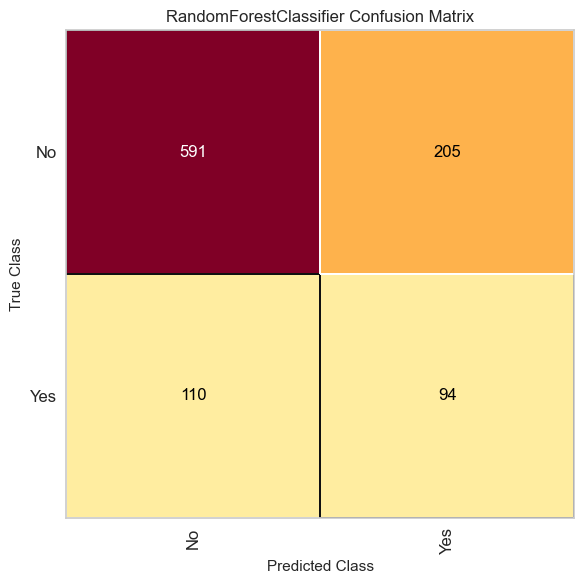

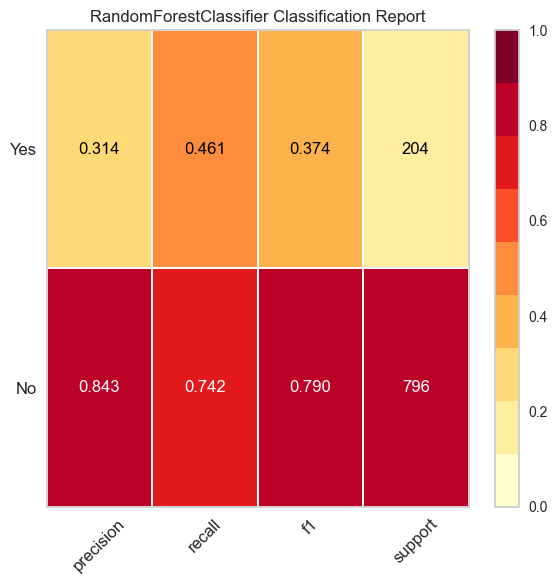

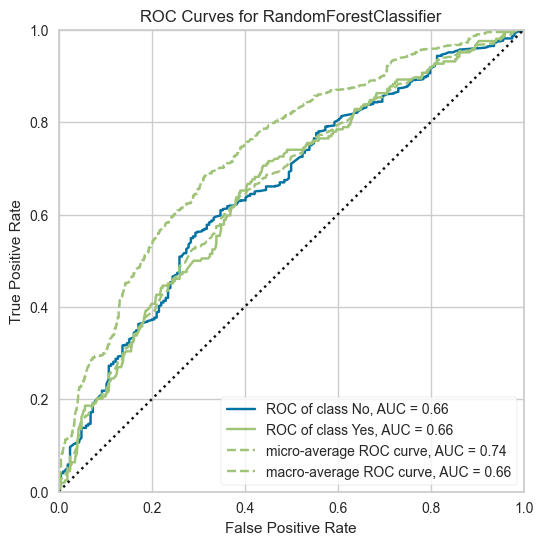

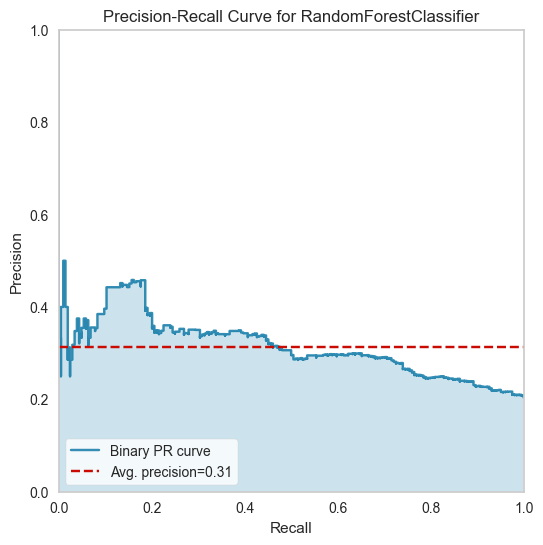

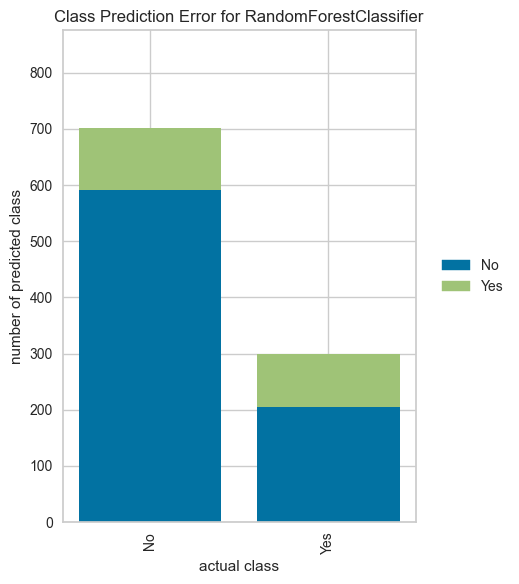

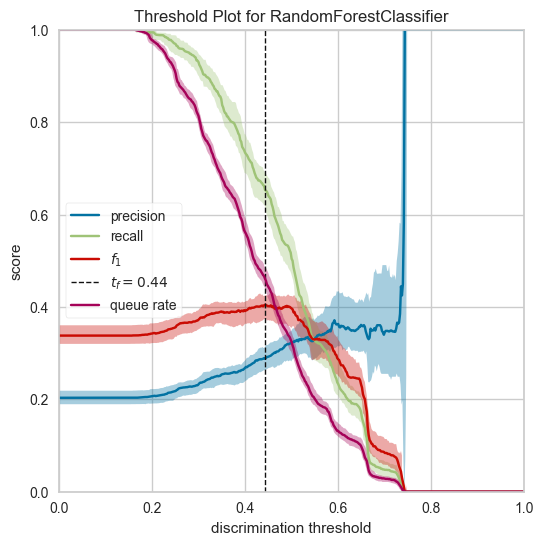

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [53]:
# Evaluate the model using Yellowbrick with smote_pipeline_rf

# Create and display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(smote_pipeline_rf, classes=["No", "Yes"], ax=ax)
cm_viz.score(X_test, y_test)
cm_viz.show()

# Create and display the classification report
fig, ax = plt.subplots(figsize=(6, 6))
cr_viz = ClassificationReport(smote_pipeline_rf, classes=["No", "Yes"], support=True, ax=ax)
cr_viz.score(X_test, y_test)
cr_viz.show()

# Create and display the ROC AUC curve
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(smote_pipeline_rf, classes=["No", "Yes"], ax=ax)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

# Create and display the precision-recall curve
fig, ax = plt.subplots(figsize=(6, 6))
prc_viz = PrecisionRecallCurve(smote_pipeline_rf, ax=ax)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.show()

# Create and display the class prediction error plot
fig, ax = plt.subplots(figsize=(6, 6))
cpe_viz = ClassPredictionError(smote_pipeline_rf, classes=["No", "Yes"], ax=ax)
cpe_viz.score(X_test, y_test)
cpe_viz.show()

# Create and display the discrimination threshold plot
fig, ax = plt.subplots(figsize=(6, 6))
dt_viz = DiscriminationThreshold(smote_pipeline_rf, ax=ax)
dt_viz.fit(X_train, y_train)
dt_viz.show()

**Adaboost Model**

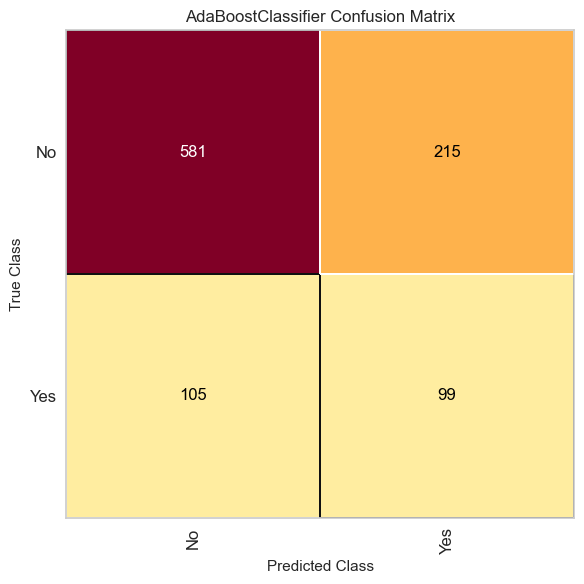

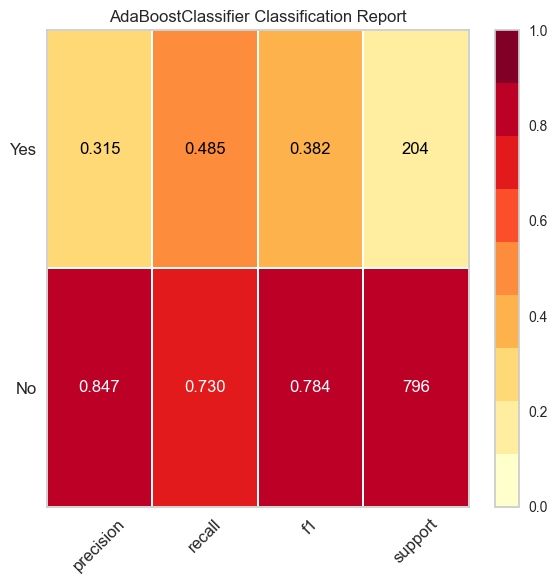

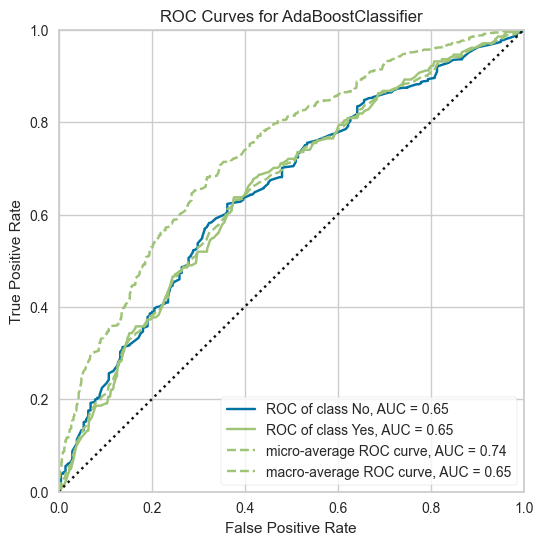

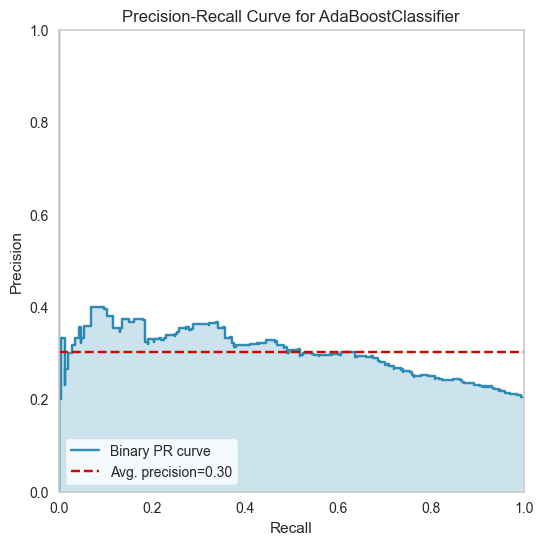

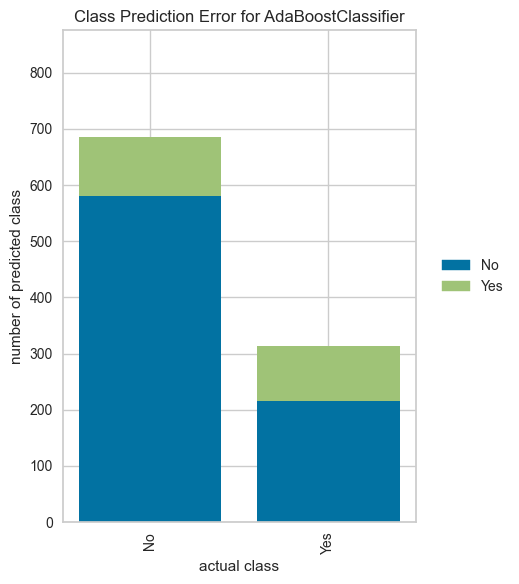

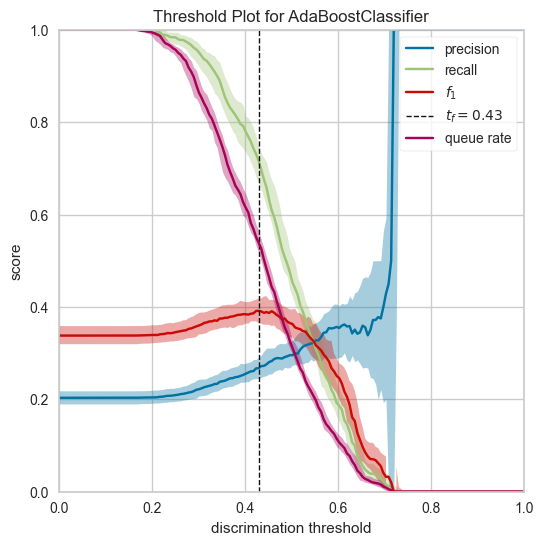

<Axes: title={'center': 'Threshold Plot for AdaBoostClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [55]:
# Evaluate the model using Yellowbrick with smote_pipeline_ab

# Create and display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(smote_pipeline_ab, classes=["No", "Yes"], ax=ax)
cm_viz.score(X_test, y_test)
cm_viz.show()

# Create and display the classification report
fig, ax = plt.subplots(figsize=(6, 6))
cr_viz = ClassificationReport(smote_pipeline_ab, classes=["No", "Yes"], support=True, ax=ax)
cr_viz.score(X_test, y_test)
cr_viz.show()

# Create and display the ROC AUC curve
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(smote_pipeline_ab, classes=["No", "Yes"], ax=ax)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

# Create and display the precision-recall curve
fig, ax = plt.subplots(figsize=(6, 6))
prc_viz = PrecisionRecallCurve(smote_pipeline_ab, ax=ax)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.show()

# Create and display the class prediction error plot
fig, ax = plt.subplots(figsize=(6, 6))
cpe_viz = ClassPredictionError(smote_pipeline_ab, classes=["No", "Yes"], ax=ax)
cpe_viz.score(X_test, y_test)
cpe_viz.show()

# Create and display the discrimination threshold plot
fig, ax = plt.subplots(figsize=(6, 6))
dt_viz = DiscriminationThreshold(smote_pipeline_ab, ax=ax)
dt_viz.fit(X_train, y_train)
dt_viz.show()


**Gradient Boosting Model**

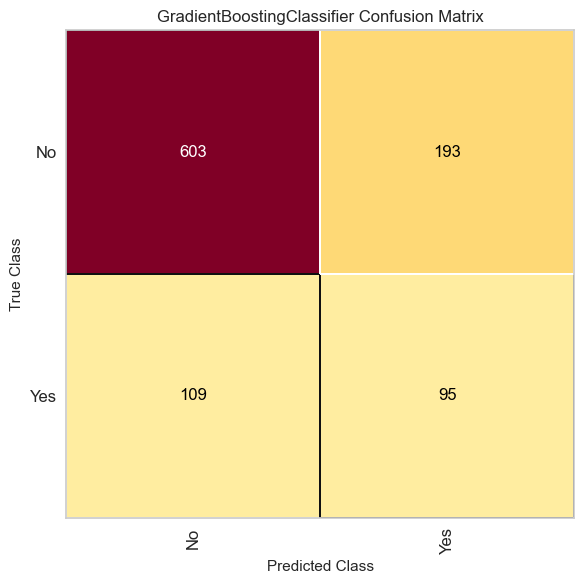

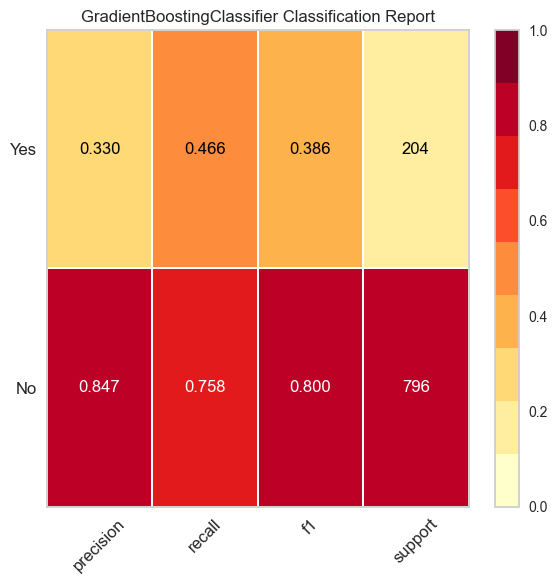

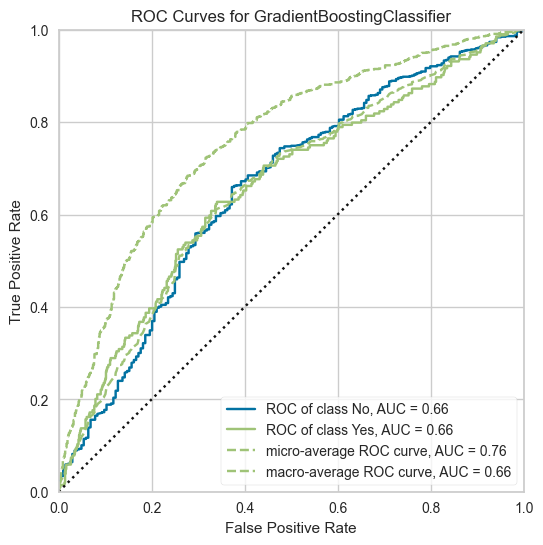

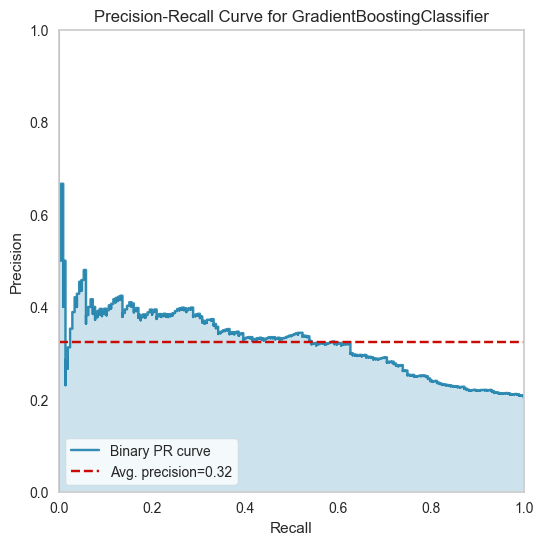

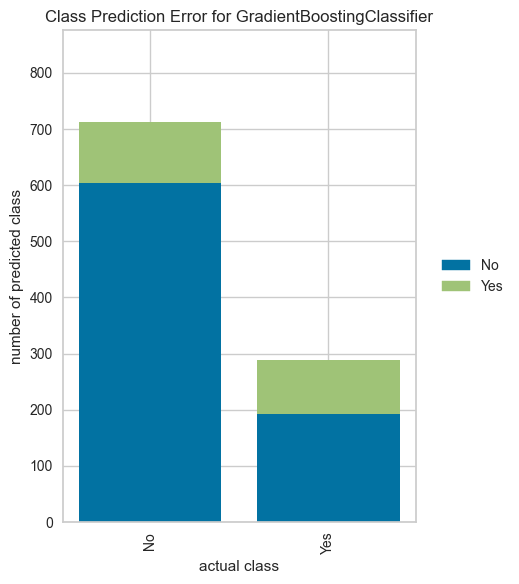

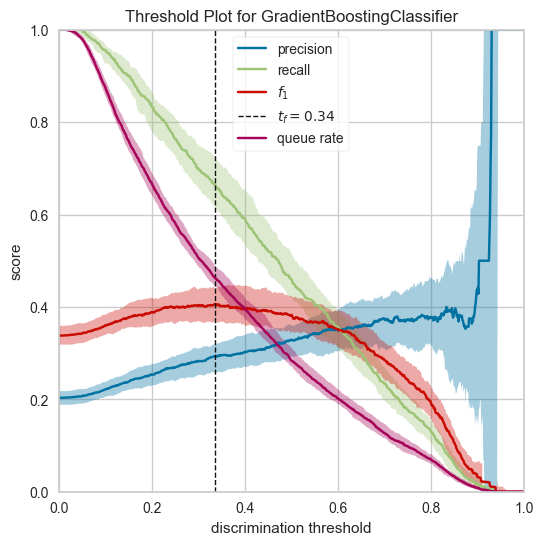

<Axes: title={'center': 'Threshold Plot for GradientBoostingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [54]:
# Evaluate the model using Yellowbrick with smote_pipeline_gb

# Create and display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(smote_pipeline_gb, classes=["No", "Yes"], ax=ax)
cm_viz.score(X_test, y_test)
cm_viz.show()

# Create and display the classification report
fig, ax = plt.subplots(figsize=(6, 6))
cr_viz = ClassificationReport(smote_pipeline_gb, classes=["No", "Yes"], support=True, ax=ax)
cr_viz.score(X_test, y_test)
cr_viz.show()

# Create and display the ROC AUC curve
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(smote_pipeline_gb, classes=["No", "Yes"], ax=ax)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

# Create and display the precision-recall curve
fig, ax = plt.subplots(figsize=(6, 6))
prc_viz = PrecisionRecallCurve(smote_pipeline_gb, ax=ax)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.show()

# Create and display the class prediction error plot
fig, ax = plt.subplots(figsize=(6, 6))
cpe_viz = ClassPredictionError(smote_pipeline_gb, classes=["No", "Yes"], ax=ax)
cpe_viz.score(X_test, y_test)
cpe_viz.show()

# Create and display the discrimination threshold plot
fig, ax = plt.subplots(figsize=(6, 6))
dt_viz = DiscriminationThreshold(smote_pipeline_gb, ax=ax)
dt_viz.fit(X_train, y_train)
dt_viz.show()


# Model Performance Comparison

**Random Forest**
**Training Performance:**
- **Accuracy:** 69.1%
- **Precision:** 32.7%
- **Recall:** 48.8%
- **F1 Score:** 39.2%

**Testing Performance:**
- **Accuracy:** 68.5%
- **Precision:** 31.4%
- **Recall:** 46.1%
- **F1 Score:** 37.4%

**AdaBoost**
**Training Performance:**
- **Accuracy:** 67.2%
- **Precision:** 30.3%
- **Recall:** 46.9%
- **F1 Score:** 36.8%

**Testing Performance:**
- **Accuracy:** 68.0%
- **Precision:** 31.5%
- **Recall:** 48.5%
- **F1 Score:** 38.2%

**Gradient Boosting**
**Training Performance:**
- **Accuracy:** 72.4%
- **Precision:** 37.2%
- **Recall:** 51.6%
- **F1 Score:** 43.3%

**Testing Performance:**
- **Accuracy:** 69.8%
- **Precision:** 33.0%
- **Recall:** 46.6%
- **F1 Score:** 38.6%

**Analysis**
1. **Accuracy:**
   - Gradient Boosting has the highest accuracy in both training (72.4%) and testing (69.8%).
   - Random Forest and AdaBoost have similar accuracy in testing (~68%).

2. **Precision:**
   - Gradient Boosting achieves the highest precision in both training (37.2%) and testing (33.0%).
   - AdaBoost and Random Forest show lower precision, indicating a higher rate of false positives.

3. **Recall:**
   - Gradient Boosting outperforms in recall with 51.6% in training and 46.6% in testing.
   - AdaBoost and Random Forest have similar recall values, but Gradient Boosting maintains a higher recall, indicating better true positive rates.

4. **F1 Score:**
   - Gradient Boosting has the highest F1 Score in both training (43.3%) and testing (38.6%), balancing precision and recall better than the other models.

**Conclusion**
Gradient Boosting outperforms Random Forest and AdaBoost across all metrics, particularly in precision, recall, and F1 Score. This suggests that Gradient Boosting is the most effective model for this dataset, providing a better balance between identifying true positives and minimizing false positives. The ROC-AUC and precision-recall curves further support Gradient Boosting's superior performance.


### Step 4: Recommend the best model (Random Forest or Boosting) and explain why. [2 marks]

#### Recommendation and explanation:

Best model:


Explanation:

End of Document